In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import importlib

from astroLuSt.physics import asteroseismology
from astroLuSt.physics import photometry as alpp
from astroLuSt.synthetics import images as alsi

importlib.reload(asteroseismology)
importlib.reload(alpp)
importlib.reload(alsi)

<module 'astroLuSt.synthetics.images' from 'c:\\Users\\lukas\\Documents\\GitHub\\astroLuSt\\demos\\..\\astroLuSt\\synthetics\\images.py'>

# Magnitudes and Fluxes

In [2]:
m = 10
m_ref = 5
f_ref = 2
d = 20 #pc
plx = 1/d #arcsec

## Converting Magnitudes and Fluxes

In [3]:
f = alpp.mags2fluxes(m=m, m_ref=m_ref, f_ref=5)
print(f'Flux from mags: {f}')
m = alpp.fluxes2mags(f=f, f_ref=f_ref, m_ref=m_ref)
print(f'Mag from fluxes: {m} mag')

Flux from mags: 0.05
Mag from fluxes: 9.005149978319906 mag


## Distance Modulus

In [4]:
DM = alpp.DistanceModule(m=m, M=None, d=d, plx=None)

print(DM)



DistanceModule(
    m=9.005149978319906, M=7.5,
    d=20, plx=0.05,
)


## Converting to Wesenheit Magnitude

In [5]:
W = alpp.wesenheit_magnitude(M=DM.M, CI=0.3, R=0)
print(f'Wesenheit Magnitude: {W} mag')

Wesenheit Magnitude: 7.5 mag


## Adding Magnitudes and Estimating Target Star Contribution

Generate some "stars" on a "sky background"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(21, 100, 100, 2)


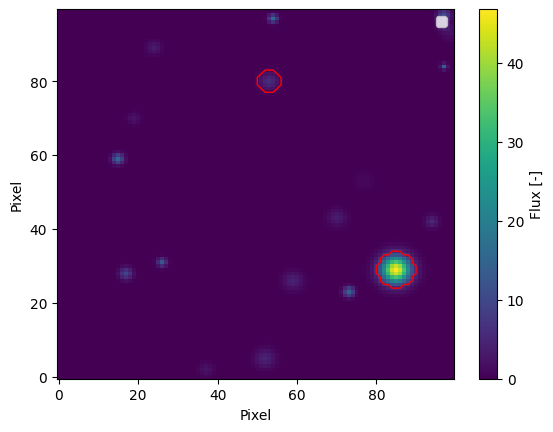

In [228]:
importlib.reload(alsi)


TPF = alsi.TPF(
    size=100,
    store_stars=True
)

TPF.add_noise()
# TPF.add_stars(pos=np.array([[50,50],[10,10],[30,70]]), f=[10,20,50])
TPF.add_stars(pos='random', random_config={'nstars':20})
# TPF.add_stars(pos=np.array([[50,50]]), f=[1000], aperture=[10])
TPF.add_stars(pos='random', random_config={'nstars':1, 'fmin':1500,'fmax':2000, 'apmin':15, 'apmax':25})

fig, axs = TPF.plot_result(plot_apertures=range(-2,0,1))

C:\Users\lukas\AppData\Local\Temp\ipykernel_52888\3440036888.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 49 + 1) instead
  poss = np.random.random_integers(0, npixels-1, size=(nstars,2))
C:\Users\lukas\AppData\Local\Temp\ipykernel_52888\3440036888.py:5: DeprecationWarning: This function is deprecated. Please call randint(-5.0, 5.0 + 1) instead
  mags = np.random.random_integers(0-mag_range/2, 0+mag_range/2, size=(nstars,1))


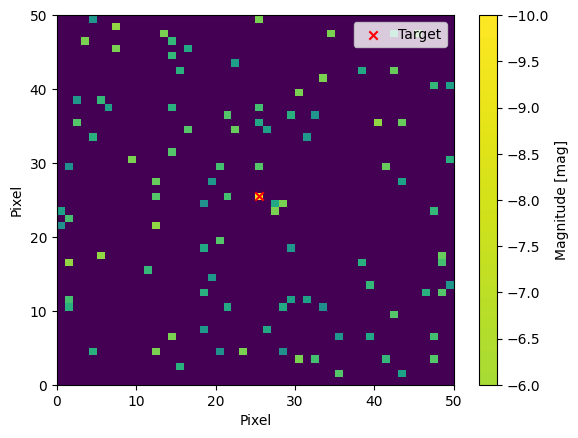

In [6]:
nstars = 100
npixels = 50
mag_range = 10
poss = np.random.random_integers(0, npixels-1, size=(nstars,2))
mags = np.random.random_integers(0-mag_range/2, 0+mag_range/2, size=(nstars,1))
stars = np.append(poss, mags, axis=1)

#generate target star
star_targ = np.array([npixels//2,npixels//2, -10])

#sky background
obs = np.zeros((npixels,npixels)) + 20

#add stars of different magnitude
obs[stars[:,0],stars[:,1]] = stars[:,2].flatten()

#add target star
obs[star_targ[0], star_targ[1]] = star_targ[2]



fig = plt.figure()
ax1 = fig.add_subplot(111)
mesh = ax1.pcolormesh(obs, cmap='viridis_r')
ax1.scatter(*star_targ[:2]+.5, marker='x', c='r', label='Target')

ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')

cbar = fig.colorbar(mesh, ax=ax1)
cbar.ax.invert_yaxis()
cbar.ax.set_ylim(0-mag_range/2-1)
cbar.set_label('Magnitude [mag]')

ax1.legend()

plt.show()

Calculate total magnitude of generated (contaminant) stars, weighted by distance to target star.

In [236]:
#calculate distances
dists = np.sqrt(np.sum((stars[:,:2] - star_targ[:2])**2, axis=1))
w = dists/dists.max()   #normalize distances to a max of

m_tot = alpp.mags_sum(m=stars[:,2], w=w)
print(f'Total magnitude of contaminants: {m_tot:.5f} mag')


Total magnitude of contaminants: -7.21689 mag


Calculate fractional contribution of the target star (single target)

In [237]:

m_cont_pre = alpp.mags_contribution(m=star_targ[2], m_cont=m_tot)           #using calculated total magnitude
m_cont_fly = alpp.mags_contribution(m=star_targ[2], m_cont=stars[:,2], w=w) #calculate total magnitude on the fly

print(f'Contribution of Target (precalculated): {m_cont_pre:.3f}')
print(f'Contribution of Target (on the fly):    {m_cont_fly:.3f}')


Contribution of Target (precalculated): 0.928
Contribution of Target (on the fly):    0.928


Calculate fractional contribution of the target stars (multiple)

In [238]:

multi = np.array([star_targ[2], star_targ[2]/2])

m_cont_fly = alpp.mags_contribution(m=multi, m_cont=stars[:,2], w=w) #calculate total magnitude on the fly

print(f'Contribution of Target (on the fly): {m_cont_fly}')


Contribution of Target (on the fly): [0.92846485 0.11488086]


# Asteroseismic Scaling Relations

See for example [Gaulme et al., (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..121G/abstract) and references therein.

In [239]:
SR = asteroseismology.ScalingRelations(
    nu_max  =np.array([3100,  1573, 1354]),
    delta_nu=np.array([135.2, 80.62, 73.22]),
    t_eff   =np.array([5777,  6433, 5645]),
    e_nu_max=np.array([np.nan, 11, 30]),
    e_delta_nu=np.array([np.nan, 1.88, 2.13]),
    e_t_eff=np.array([np.nan, 80, 80]),
    zeta_corr=False
)
print(SR)

mass = SR.get_mass()
radius = SR.get_radius()
logg = SR.get_logg()
logL = SR.get_luminosity()

df = SR.results2pandas()

df

ScalingRelations(
    nu_max=array([3100, 1573, 1354]), 
    delta_nu=array([135.2 ,  80.62,  73.22]), 
    t_eff=array([5777, 6433, 5645]), 
    e_nu_max=array([nan, 11., 30.]), e_delta_nu=array([ nan, 1.88, 2.13]), e_t_eff=array([nan, 80., 80.]), 
    nu_max_sun=3100, delta_nu_sun=135.2, t_eff_sun=5777, logg_sun=5777, 
    zeta_corr=False, 
)


,nu_max,e_nu_max,delta_nu,e_delta_nu,t_eff,e_t_eff,zeta_corr,mass_seism,e_mass_seism,radius_seism,e_radius_seism,luminosity_seism,e_luminosity_seism,logg_seism,e_logg_seism
0,3100.0,NaN,135.20,NaN,5777.0,NaN,0.0,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN
1,1573.0,11.0,80.62,1.88,6433.0,80.0,0.0,1.214237,0.118279,1.505880,0.071632,3.486788,0.393907,0.535455,0.009358
2,1354.0,30.0,73.22,2.13,5645.0,80.0,0.0,0.935624,0.126949,1.472081,0.092239,1.975649,0.283040,0.431755,0.023262
